In [6]:
import math, random, pickle, os, copy, itertools, sys
import torch, logging, scipy.io
import numpy as np
import pandas as pd
from numpy import random
from datetime import datetime
import matplotlib.pyplot as plt
from collections.abc import Iterable

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from city_pv_uni_modal import CityPV_UniModal
from city_pv_multi_modal import CityPV_MultiModal
from utils_pv import get_available_modules, get_available_inverters, visualize_pv, visualize_env
from samples.data_sim import remove_feature, PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)


# Bi-Modal Heterogeneous Clients Distribution
All clients are located in Lausanne and share the same latitude and longitude. Some clients face teh east and some the west


Difference among clients in:
* PV cell orientation (tilt and azimuth)
* temperature and wind speed
* altitude from see level
* PV module and inverter technology
* Shaddows


Train-Test Split
* only in June and July
* 15 years of data
* different training scenarios using 2 weeks, 1 year, 5 years, and 15 years of data for training between 2005-2018
* always test on June and July of 2019

In [10]:
# get feature names and lags from UniModal env
filename_env_uni = os.getcwd() + '/../../saved_results/PV_UniModal_env'
file = open(filename_env_uni, 'rb')
env_dict_uni = pickle.load(file)
file.close()

feature_names_uni = env_dict_uni['feature_names']
selected_lags = [int(x.split()[-1]) for x in feature_names_uni if x.startswith('lag')] 
selected_nonar = [x for x in feature_names_uni if not x.startswith('lag')] 
print('selected lags: ', selected_lags)
print('selected non-autoregressors: ', selected_nonar)


selected lags:  [1, 2, 4, 18, 20, 22, 43, 70, 74, 121, 145]
selected non-autoregressors:  ['H_sun', 'T2m', 'WS10m', 'station_irrad_direct_prev']


[INFO] generating data for Lausanne
[INFO] generating data for Lausanne
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples


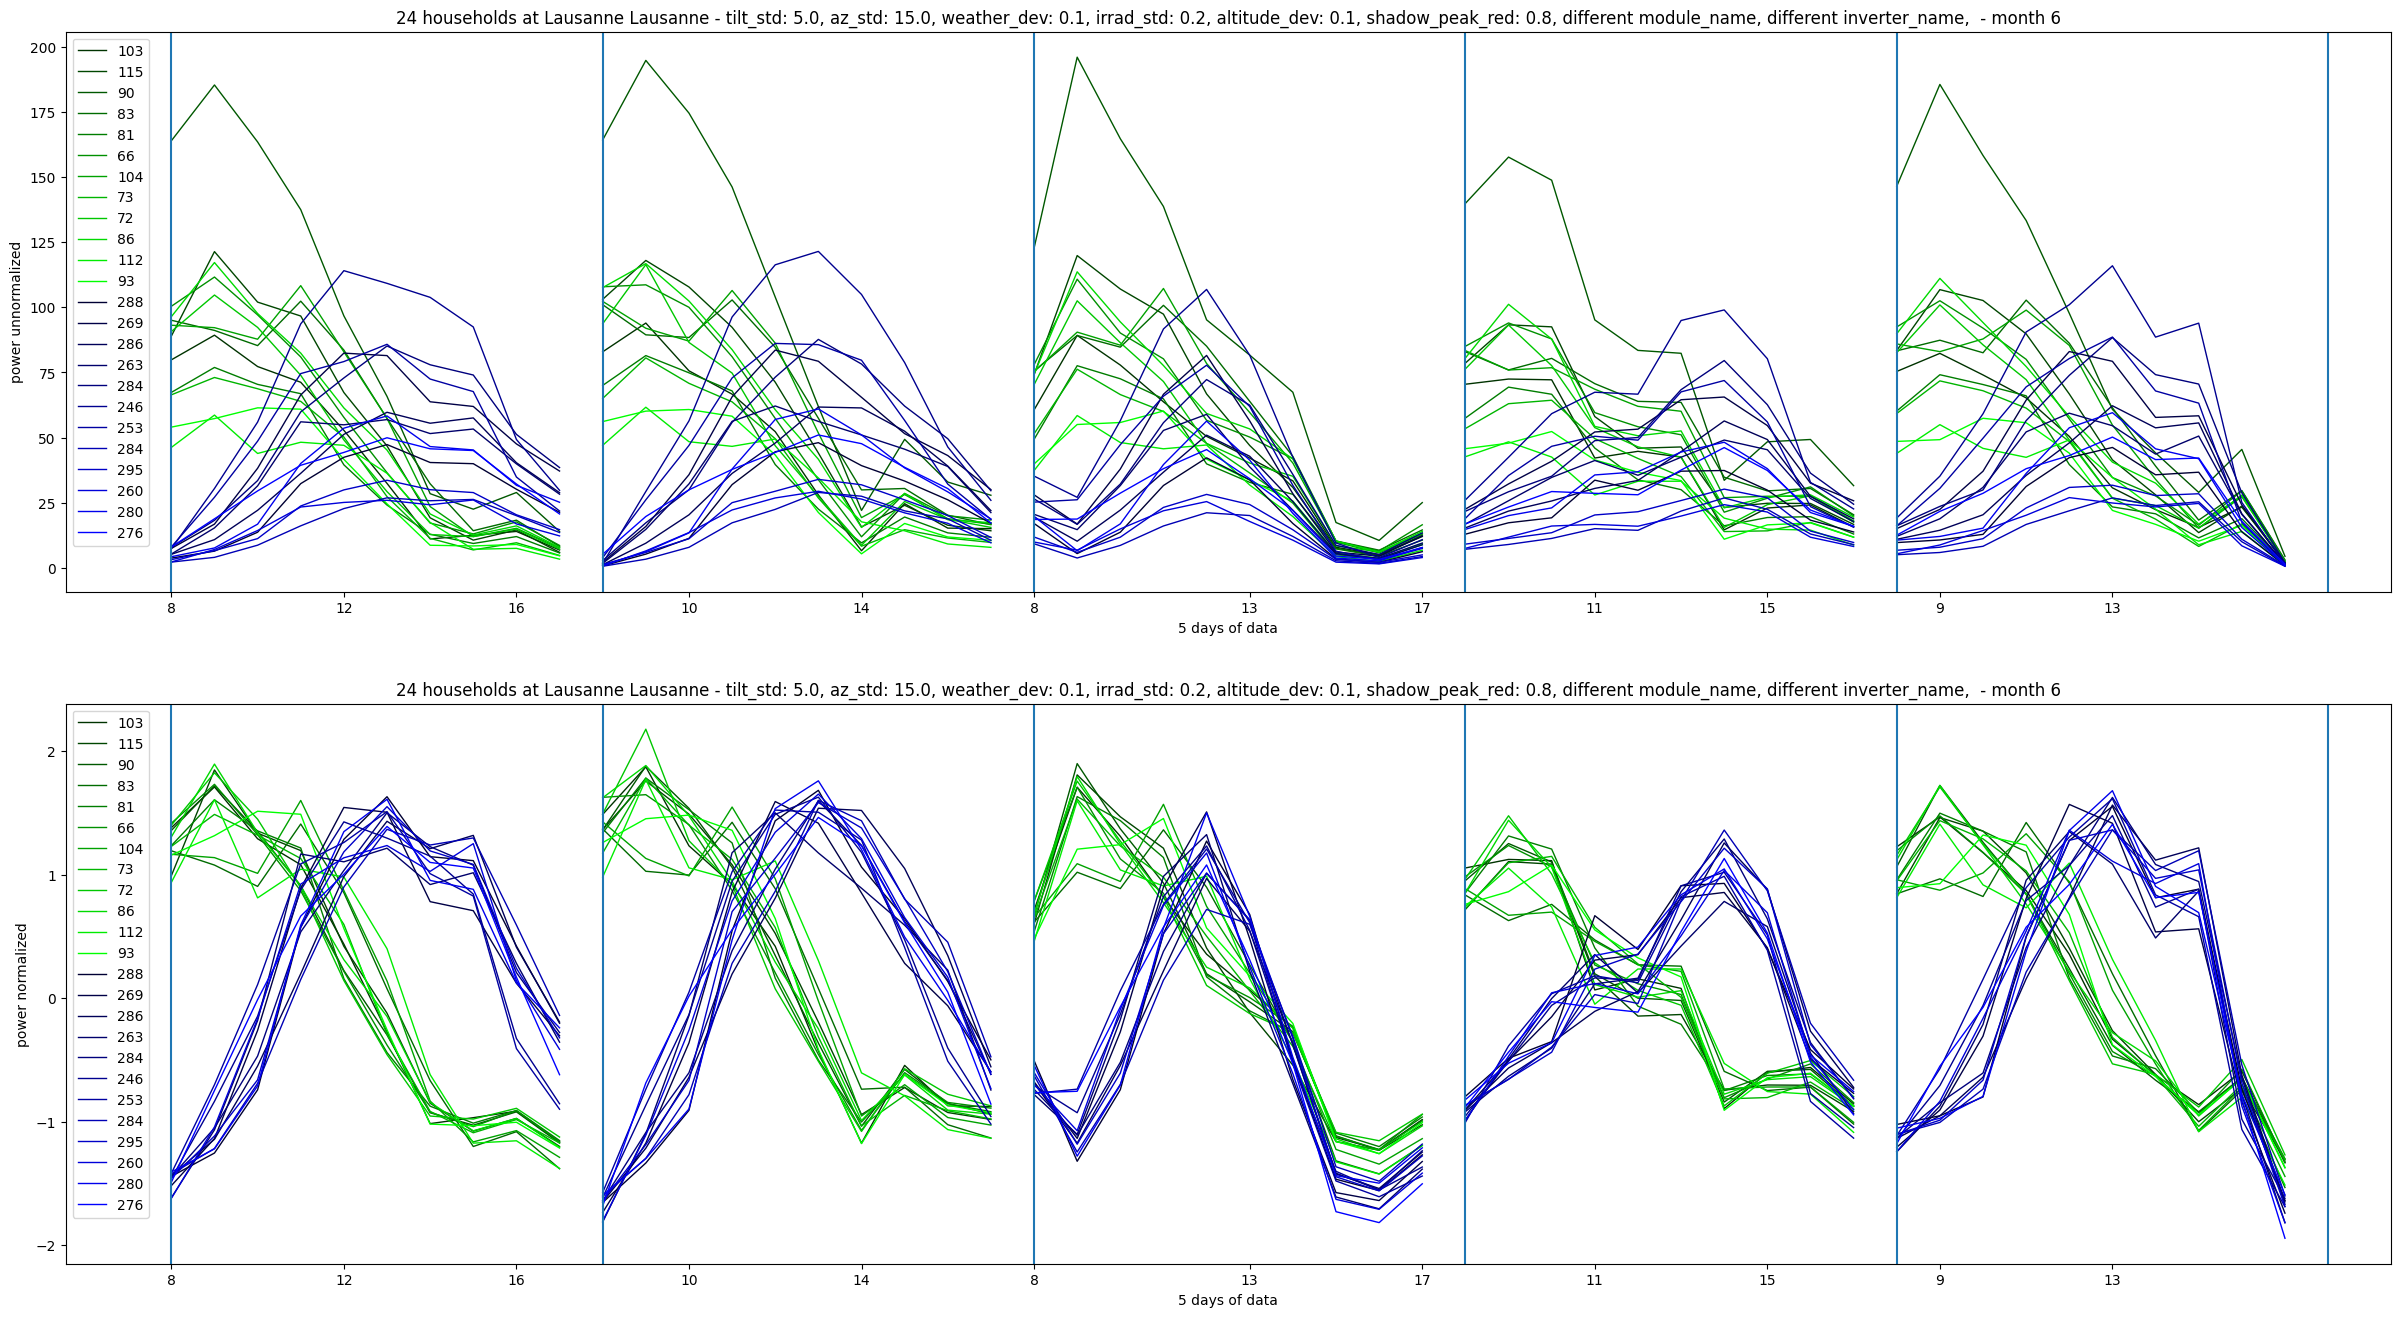

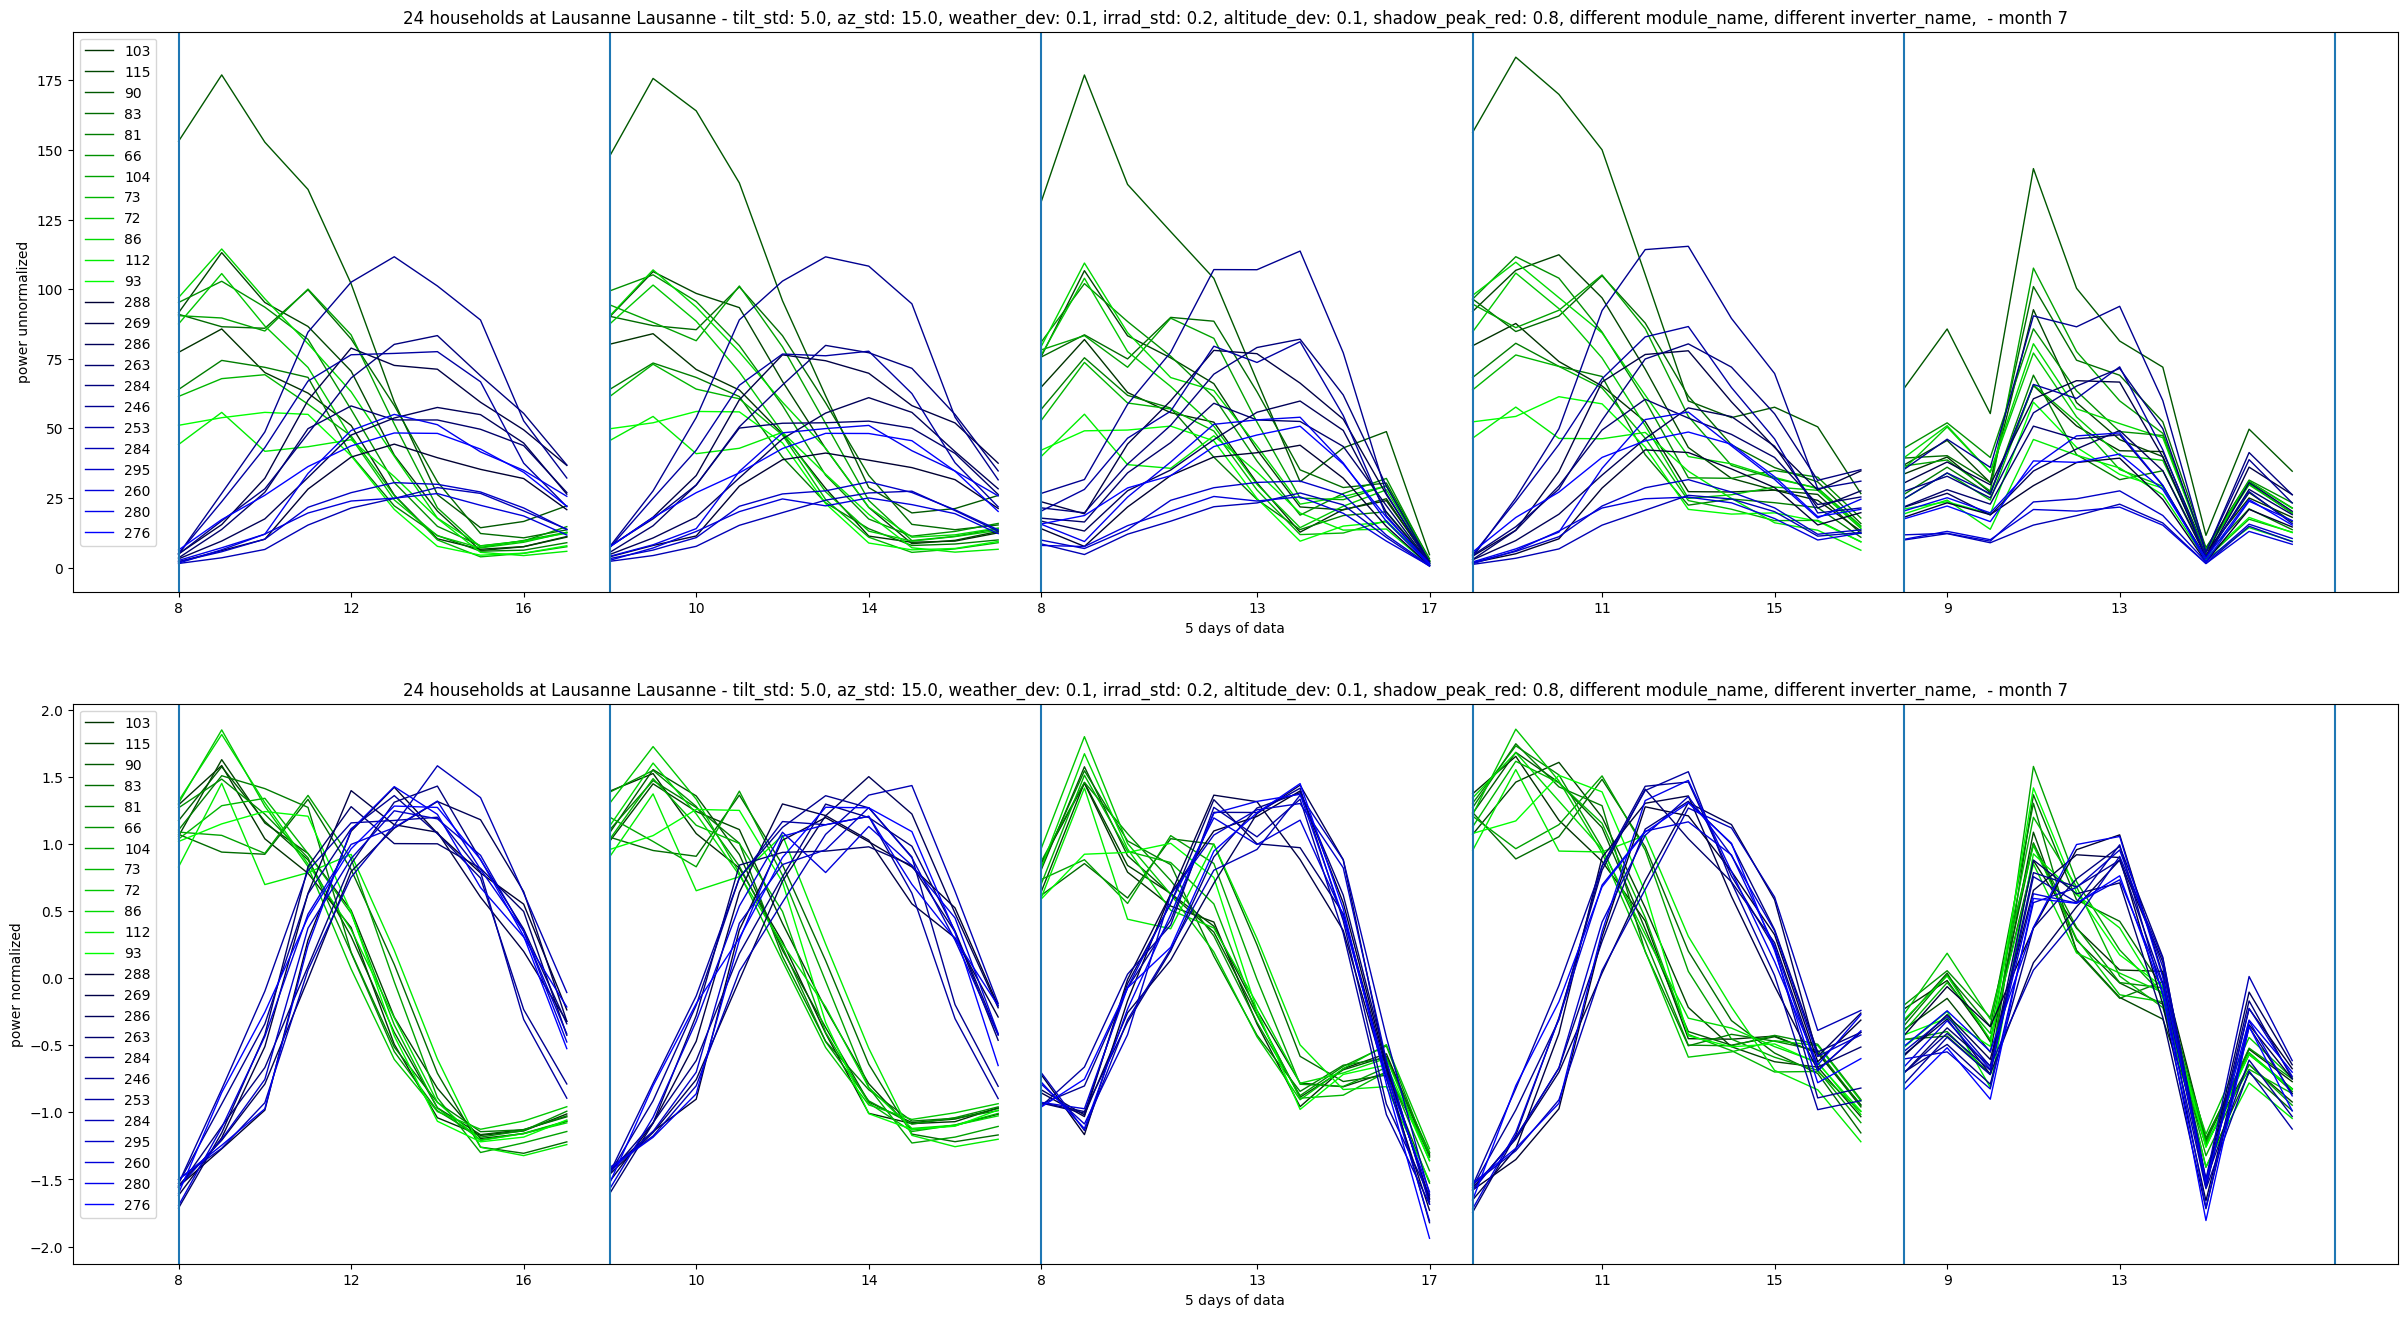

In [11]:
num_clients=24
city_names = ['Lausanne', 'Lausanne']
env_dict = {
    'city_names':city_names,
    'num_clients': num_clients, 'num_modes': len(city_names),
    'az_mean':[90, 270],
    'tilt_std': 5, 'az_std':15, 'weather_dev':0.1,
    'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.8,
    'module_name': get_available_modules('sandia')[0:num_clients],
    'inverter_name': get_available_inverters('cec')[0:num_clients],
    # fields same as the uni-modal experiment
    'lags':selected_lags, 
    'months':env_dict_uni['months'], 'hours':env_dict_uni['hours'],
    'use_station_irrad_direct':env_dict_uni['use_station_irrad_direct'], 
    'use_station_irrad_diffuse':env_dict_uni['use_station_irrad_diffuse'],
    'delay_irrad':env_dict_uni['delay_irrad'], 
    'remove_constant_cols':env_dict_uni['remove_constant_cols'], 
    # training scenarios
    'train_scenarios':{
        'sml':{'m_train':150, 'train_years':[2018], 'valid_years':2019},
        '1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019},
        '5y':{'m_train':None, 'train_years':np.arange(2014, 2019), 'valid_years':2019},
        '14y':{'m_train':None, 'train_years':np.arange(2005, 2019), 'valid_years':2019}}}
env_dict = PVDataset(env_dict).generate_clients_data(shuffle=False)

# remove unused non-autoregressive features
non_ar_feat_remove = [x for x in env_dict['feature_names'] if not ((x in selected_nonar) or x.startswith('lag'))]
for feature_name in non_ar_feat_remove:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)

assert env_dict['feature_names'] == env_dict_uni['feature_names']

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
visualize_env(env_dict, num_days=5, year=2018, scenario_name='1y')

In [13]:
save_env=True
load_env=False
exp_name = 'PV_BiModal'
filename_env = os.getcwd() + "/../../saved_results/" + exp_name + "_env"
if save_env:
    # save env
    file = open(filename_env, 'wb')
    pickle.dump(env_dict, file)
    msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])
elif load_env:
    file = open(filename_env, 'rb')
    env_dict = pickle.load(file)
    msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
print(msg)
file.close()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))


[INFO] saved data for 24 clients

24 households at Lausanne Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples
